# Data Challenge

# Importação de Bibliotecas

In [1]:
from glob import glob

# APIs algébricas, matemáticas e para tratamento e manipulação de dados
import numpy as np
import pandas as pd

# APIs para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração das APIs de visualização
plt.rcParams.update({'figure.figsize': (13,13)})

# APIs para aprendizado de máquina
#import tensorflow as tf
!pip install -U ppscore
import ppscore as pps
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Set de configurações de formatação

In [2]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 14,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.frameon': True,
    })

# Obtendo DataFrame

In [3]:
dataFiles = sorted(glob('Training/Small/Sample**.csv'))
dataFiles.extend(sorted(glob('Training/Large/Sample**.csv')))
dataFiles.extend(sorted(glob('Validation/Small/Sample**.csv')))
dataFiles.extend(sorted(glob('Validation/Large/Sample**.csv')))

In [4]:
#Criando dataFrames para cada arquivo
dataFrames = []

particleSizeData = pd.read_csv('Training/Training Operation Profiles of Samples.csv', ';')
particleSizeData.append(pd.read_excel('Validation/Validation Operation Profiles of Samples.xlsx'))

for file in dataFiles:
    df = pd.read_csv(file)
    df["Pressure_Diferential(psi)"] = df["Upstream_Pressure(psi)"] - df["Downstream_Pressure(psi)"] #Calculo da perda de Carga
    df["sample"] = int(file[-6:-4])
    df.join(particleSizeData.set_index('sample'), on='sample')
    first_occurence = df[df['Pressure_Diferential(psi)']>20].index[0]
    df = df.iloc[:first_occurence]
    dataFrames.append(df)
    

In [5]:
df["Pressure_Diferential(psi)"]

0        0.23750
1        0.76250
2        0.96250
3        0.98750
4        0.28125
          ...   
1727    18.61875
1728    19.38125
1729    19.94375
1730    19.45625
1731    18.96875
Name: Pressure_Diferential(psi), Length: 1732, dtype: float64

In [6]:
#Criando coluna de vida util remanscente
for df in dataFrames:
    lastTime = df['Time(s)'].iloc[[-1]]
    df['Remaining_Lifespan(s)'] = [(lastTime.values[0] - instant) for instant in df['Time(s)']];

In [7]:
#Unindo dataframes em um único
dataFrame = pd.concat(dataFrames).reset_index();

In [8]:
dataFrame

index  Time(s)  Flow_Rate(ml/m)  Upstream_Pressure(psi)  \
0          0      0.0         9.935067                -0.30000   
1          1      0.1         4.110983                 0.61250   
2          2      0.2         5.098116                 1.05625   
3          3      0.3        10.231207                 1.20000   
4          4      0.4         8.355655                 0.93125   
...      ...      ...              ...                     ...   
69478   1727    172.7       406.959957                19.17500   
69479   1728    172.8       410.908489                18.18750   
69480   1729    172.9       402.813998                20.04375   
69481   1730    173.0       412.389188                20.39375   
69482   1731    173.1       411.796909                18.58125   

       Downstream_Pressure(psi)  Pressure_Diferential(psi)  sample  \
0                      -1.10625                    0.80625       1   
1                      -0.34375                    0.95625       1   
2                      -0.08125                    1.13750       1   
3                       0.84375                    0.35625       1   
4                       0.79375                    0.13750       1   
...                         ...                        ...     ...   
69478                   0.55625                   18.61875      48   
69479                  -1.19375                   19.38125      48   
69480                   0.10000                   19.94375      48   
69481                   0.93750                   19.45625      48   
69482                  -0.38750                   18.96875      48   

       Remaining_Lifespan(s)  
0                      273.3  
1                      273.2  
2                      273.1  
3                      273.0  
4                      272.9  
...                      ...  
69478                    0.4  
69479                    0.3  
69480                    0.2  
69481                    0.1  
69482                    0.0  

[69483 rows x 8 columns]

# Pré-Processamento

In [9]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69483 entries, 0 to 69482
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      69483 non-null  int64  
 1   Time(s)                    69483 non-null  float64
 2   Flow_Rate(ml/m)            69483 non-null  float64
 3   Upstream_Pressure(psi)     69483 non-null  float64
 4   Downstream_Pressure(psi)   69483 non-null  float64
 5   Pressure_Diferential(psi)  69483 non-null  float64
 6   sample                     69483 non-null  int64  
 7   Remaining_Lifespan(s)      69483 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 4.2 MB


In [10]:
dataFrame.describe()

index       Time(s)  Flow_Rate(ml/m)  Upstream_Pressure(psi)  \
count  69483.000000  69483.000000     69483.000000            69483.000000   
mean    1113.292446    111.329245       535.142015                2.872838   
std      675.047283     67.504728        91.669629                3.888707   
min        0.000000      0.000000        -3.687368               -1.281250   
25%      542.000000     54.200000       548.613541                0.831250   
50%     1085.000000    108.500000       559.373291                1.706250   
75%     1628.000000    162.800000       564.012816                3.106250   
max     2774.000000    277.400000       931.325003               20.937500   

       Downstream_Pressure(psi)  Pressure_Diferential(psi)       sample  \
count              69483.000000               69483.000000  69483.00000   
mean                   0.018781                   2.854057     21.99384   
std                    0.704217                   3.851503     16.57006   
min                   -1.937500                  -0.731250      1.00000   
25%                   -0.618750                   0.868750      7.00000   
50%                    0.131250                   1.600000     14.00000   
75%                    0.668750                   2.931250     39.00000   
max                    1.431250                  20.000000     48.00000   

       Remaining_Lifespan(s)  
count           69483.000000  
mean              111.329245  
std                67.504728  
min                 0.000000  
25%                54.200000  
50%               108.500000  
75%               162.800000  
max               277.400000

In [11]:
# Criando colunas (Particles, Particle Size e Solid Ratio)
Df = dataFrame.assign(Particles=1)
Df.loc[((Df['sample']>=1) & (Df['sample']<=16)),'Particles'] = 'Small'
Df.loc[((Df['sample']>=33) & (Df['sample']<=48)),'Particles'] = 'Large'

Df.loc[((Df['sample']>=1) & (Df['sample']<=16)),'Particle Size(micron)'] = '45-53'
Df.loc[((Df['sample']>=33) & (Df['sample']<=48)),'Particle Size(micron)'] = '63-75'

Df.loc[((Df['sample']>=1) & (Df['sample']<=4)),'Solid Ratio(%)'] = '0.4'
Df.loc[((Df['sample']>=33) & (Df['sample']<=36)),'Solid Ratio(%)'] = '0.4'
Df.loc[((Df['sample']>=5) & (Df['sample']<=8)),'Solid Ratio(%)'] = '0.425'
Df.loc[((Df['sample']>=37) & (Df['sample']<=40)),'Solid Ratio(%)'] = '0.425'
Df.loc[((Df['sample']>=9) & (Df['sample']<=12)),'Solid Ratio(%)'] = '0.45'
Df.loc[((Df['sample']>=41) & (Df['sample']<=44)),'Solid Ratio(%)'] = '0.45'
Df.loc[((Df['sample']>=13) & (Df['sample']<=16)),'Solid Ratio(%)'] = '0.475'
Df.loc[((Df['sample']>=45) & (Df['sample']<=48)),'Solid Ratio(%)'] = '0.475'

Df


index  Time(s)  Flow_Rate(ml/m)  Upstream_Pressure(psi)  \
0          0      0.0         9.935067                -0.30000   
1          1      0.1         4.110983                 0.61250   
2          2      0.2         5.098116                 1.05625   
3          3      0.3        10.231207                 1.20000   
4          4      0.4         8.355655                 0.93125   
...      ...      ...              ...                     ...   
69478   1727    172.7       406.959957                19.17500   
69479   1728    172.8       410.908489                18.18750   
69480   1729    172.9       402.813998                20.04375   
69481   1730    173.0       412.389188                20.39375   
69482   1731    173.1       411.796909                18.58125   

       Downstream_Pressure(psi)  Pressure_Diferential(psi)  sample  \
0                      -1.10625                    0.80625       1   
1                      -0.34375                    0.95625       1   
2                      -0.08125                    1.13750       1   
3                       0.84375                    0.35625       1   
4                       0.79375                    0.13750       1   
...                         ...                        ...     ...   
69478                   0.55625                   18.61875      48   
69479                  -1.19375                   19.38125      48   
69480                   0.10000                   19.94375      48   
69481                   0.93750                   19.45625      48   
69482                  -0.38750                   18.96875      48   

       Remaining_Lifespan(s) Particles Particle Size(micron) Solid Ratio(%)  
0                      273.3     Small                 45-53            0.4  
1                      273.2     Small                 45-53            0.4  
2                      273.1     Small                 45-53            0.4  
3                      273.0     Small                 45-53            0.4  
4                      272.9     Small                 45-53            0.4  
...                      ...       ...                   ...            ...  
69478                    0.4     Large                 63-75          0.475  
69479                    0.3     Large                 63-75          0.475  
69480                    0.2     Large                 63-75          0.475  
69481                    0.1     Large                 63-75          0.475  
69482                    0.0     Large                 63-75          0.475  

[69483 rows x 11 columns]

In [12]:
Df["Pressure_Diferential(psi)"].max()

20.0

KeyboardInterrupt: 

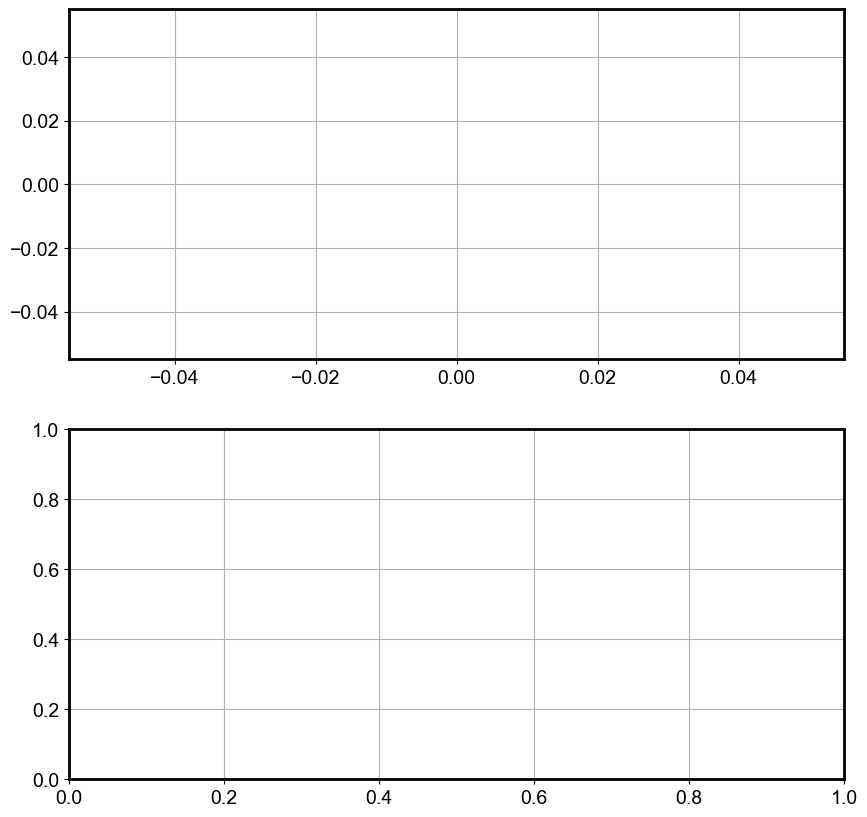

In [12]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,10))
sns.lineplot(x = 'Time(s)', y= 'Downstream_Pressure(psi)', hue= 'Particles',size='Solid Ratio(%)' , palette= 'Set1', ax=ax1, data=Df)

sns.lineplot(x = 'Time(s)', y= 'Upstream_Pressure(psi)', hue= 'Particles',size='Solid Ratio(%)', palette= 'Set1', ax=ax2, data=Df)
ax2.axhline(y=20, color='black', linestyle='dashed')

KeyboardInterrupt: 

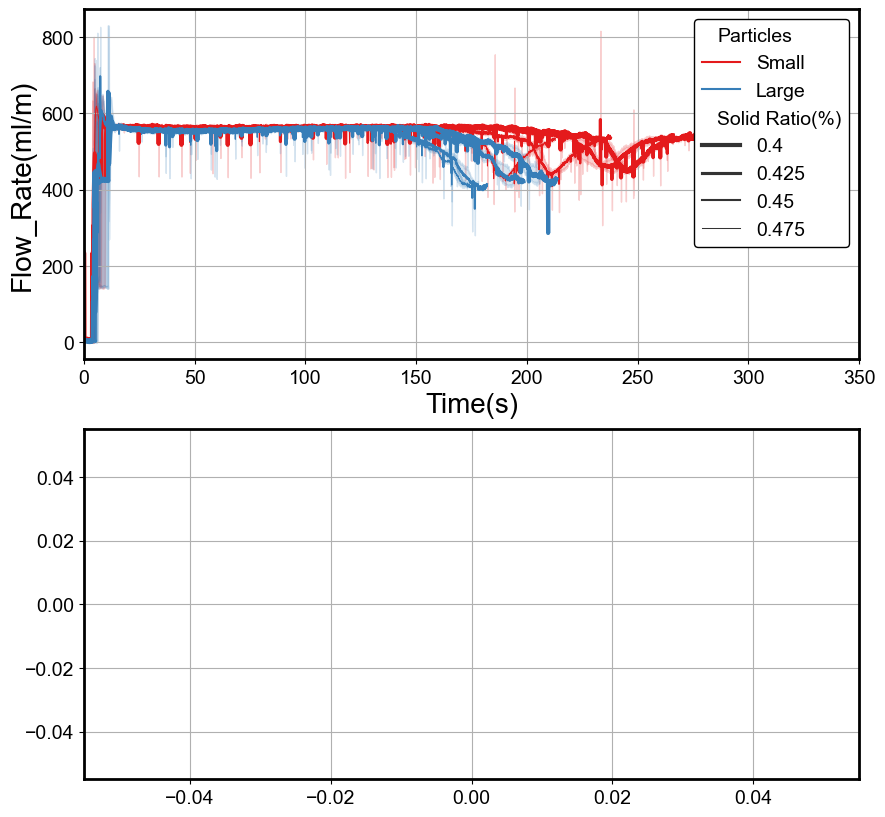

In [ ]:
# Vazão X tempo e Diferença de pressão X tempo
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,10))
sns.lineplot(x = 'Time(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles',size='Solid Ratio(%)' , palette= 'Set1', ax=ax1, data=Df)
ax1.set(xlim=(0,350))

sns.lineplot(x = 'Time(s)', y= 'Pressure_Diferential(psi)', hue= 'Particles',size='Solid Ratio(%)', palette= 'Set1', ax=ax2, data=Df)
ax2.axhline(y=20, color='black', linestyle='dashed')

<AxesSubplot:xlabel='Solid Ratio(%)', ylabel='Remaining_Lifespan(s)'>

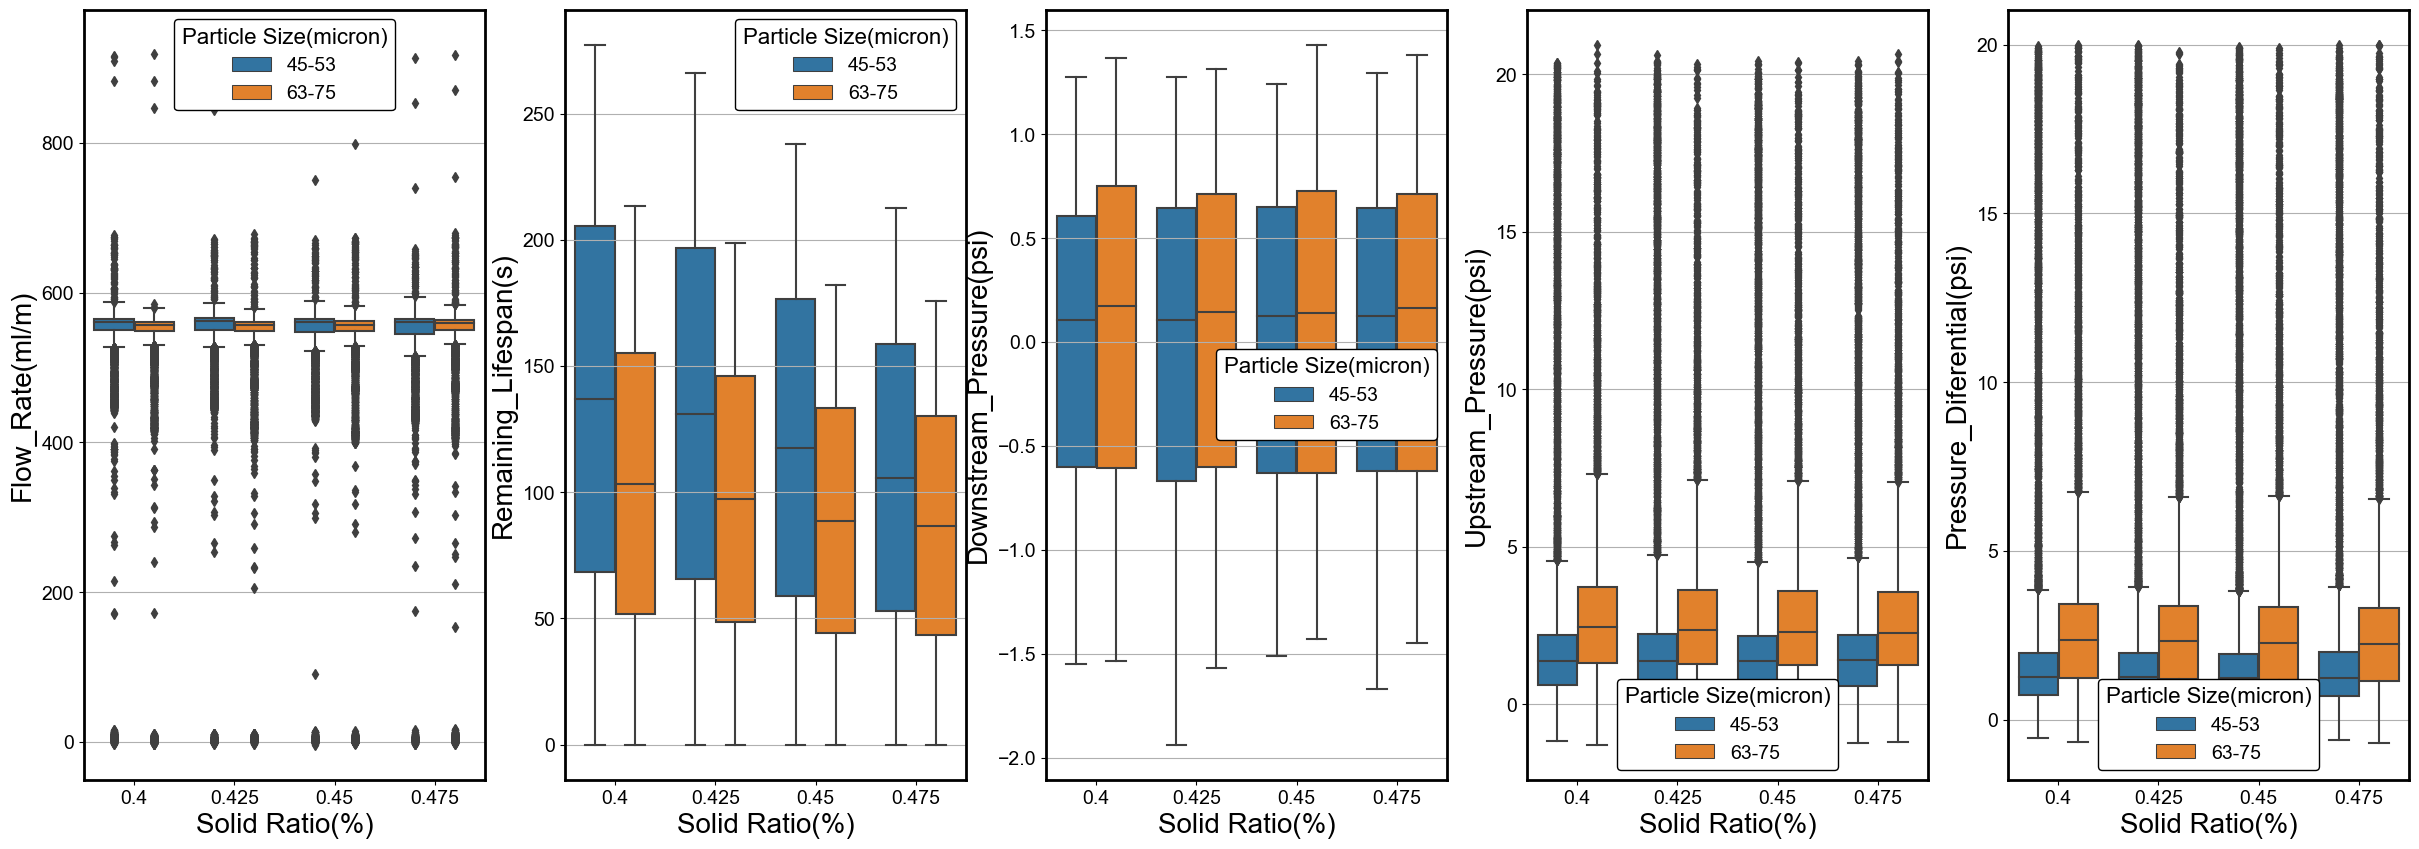

In [ ]:
fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(30,10))
sns.boxplot(x='Solid Ratio(%)',y='Flow_Rate(ml/m)',data=Df, hue="Particle Size(micron)", ax=ax)
sns.boxplot(x='Solid Ratio(%)',y='Upstream_Pressure(psi)',data=Df, hue="Particle Size(micron)", ax=ax3)
sns.boxplot(x='Solid Ratio(%)',y='Downstream_Pressure(psi)',data=Df, hue="Particle Size(micron)", ax=ax2)
sns.boxplot(x='Solid Ratio(%)',y='Pressure_Diferential(psi)',data=Df, hue="Particle Size(micron)", ax=ax4)
sns.boxplot(x='Solid Ratio(%)',y='Remaining_Lifespan(s)',data=Df, hue="Particle Size(micron)", ax=ax1)

<AxesSubplot:xlabel='Particles', ylabel='Remaining_Lifespan(s)'>

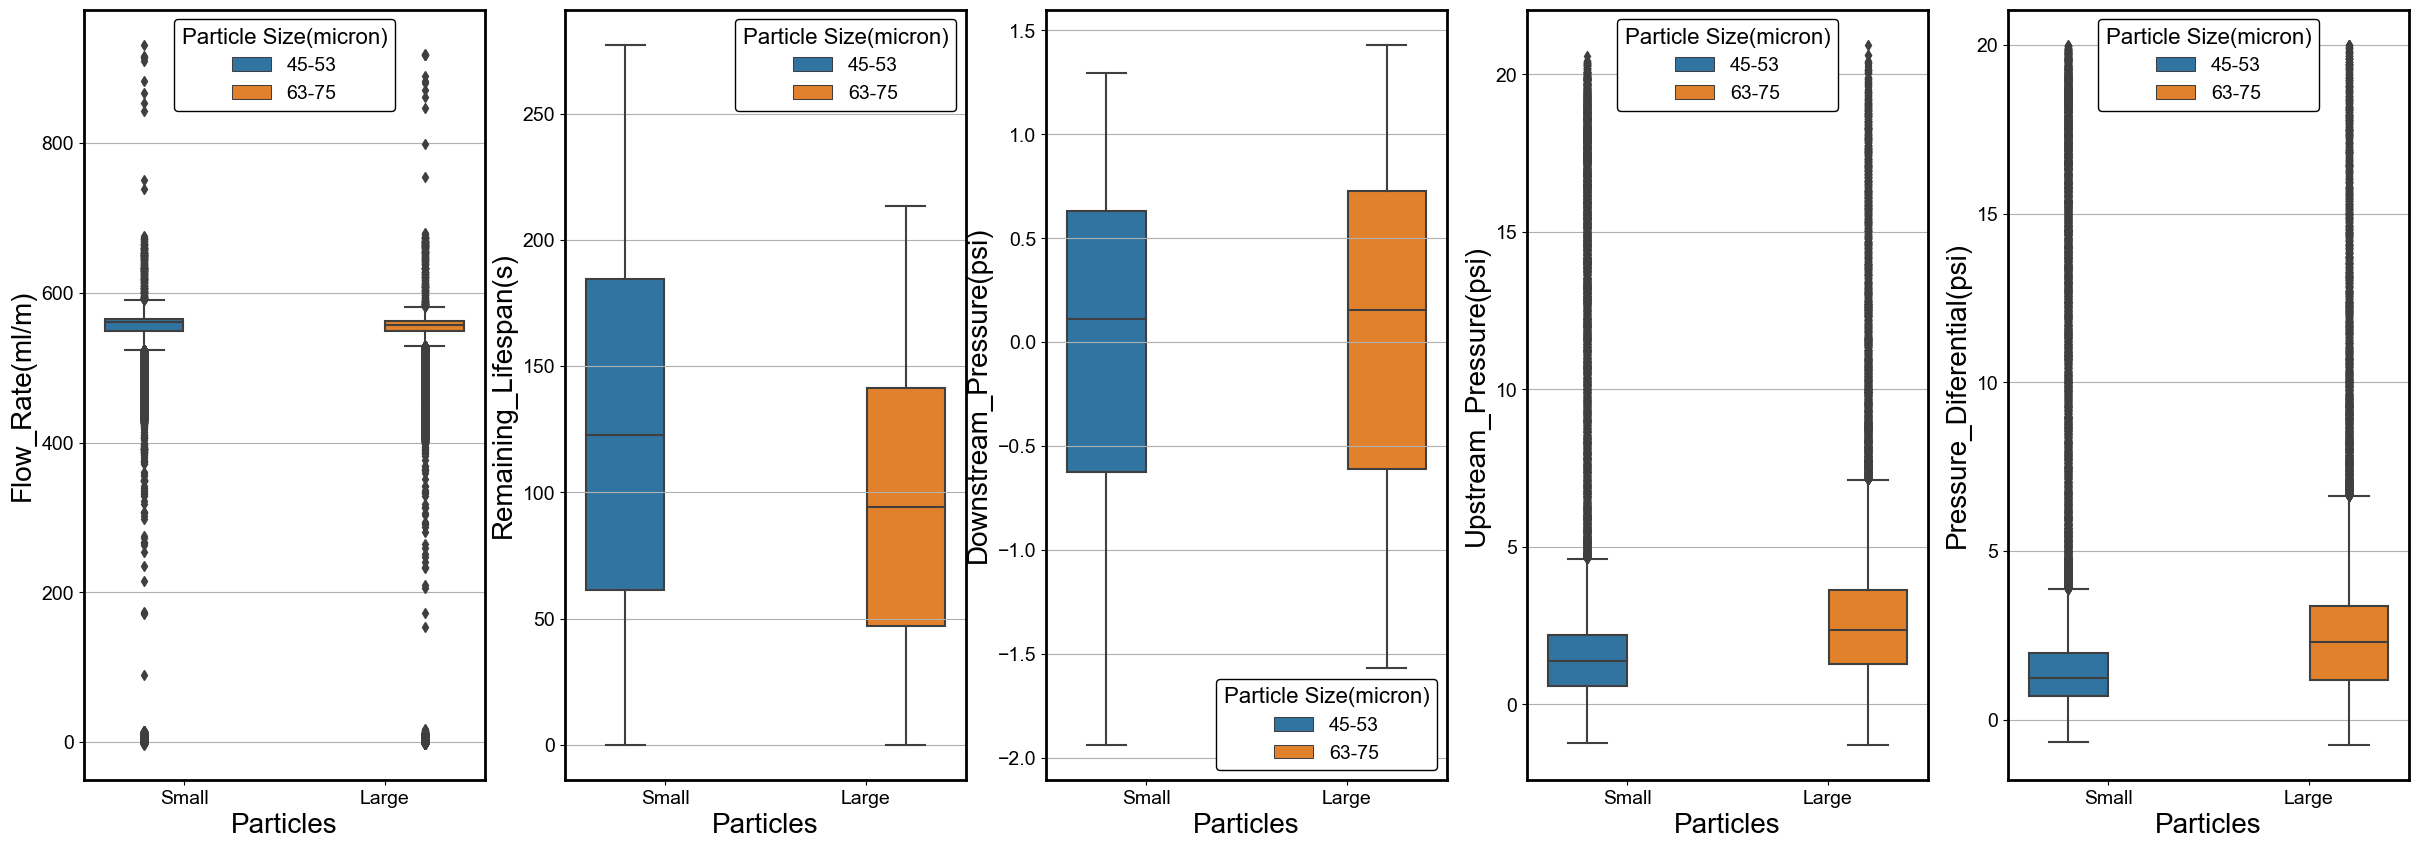

In [ ]:
# Muitos outliers em Flow Rate
fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(30,10))
sns.boxplot(x='Particles',y='Flow_Rate(ml/m)',data=Df, hue="Particle Size(micron)", ax=ax)
sns.boxplot(x='Particles',y='Upstream_Pressure(psi)',data=Df, hue="Particle Size(micron)", ax=ax3)
sns.boxplot(x='Particles',y='Downstream_Pressure(psi)',data=Df, hue="Particle Size(micron)", ax=ax2)
sns.boxplot(x='Particles',y='Pressure_Diferential(psi)',data=Df, hue="Particle Size(micron)", ax=ax4)
sns.boxplot(x='Particles',y='Remaining_Lifespan(s)',data=Df, hue="Particle Size(micron)", ax=ax1)

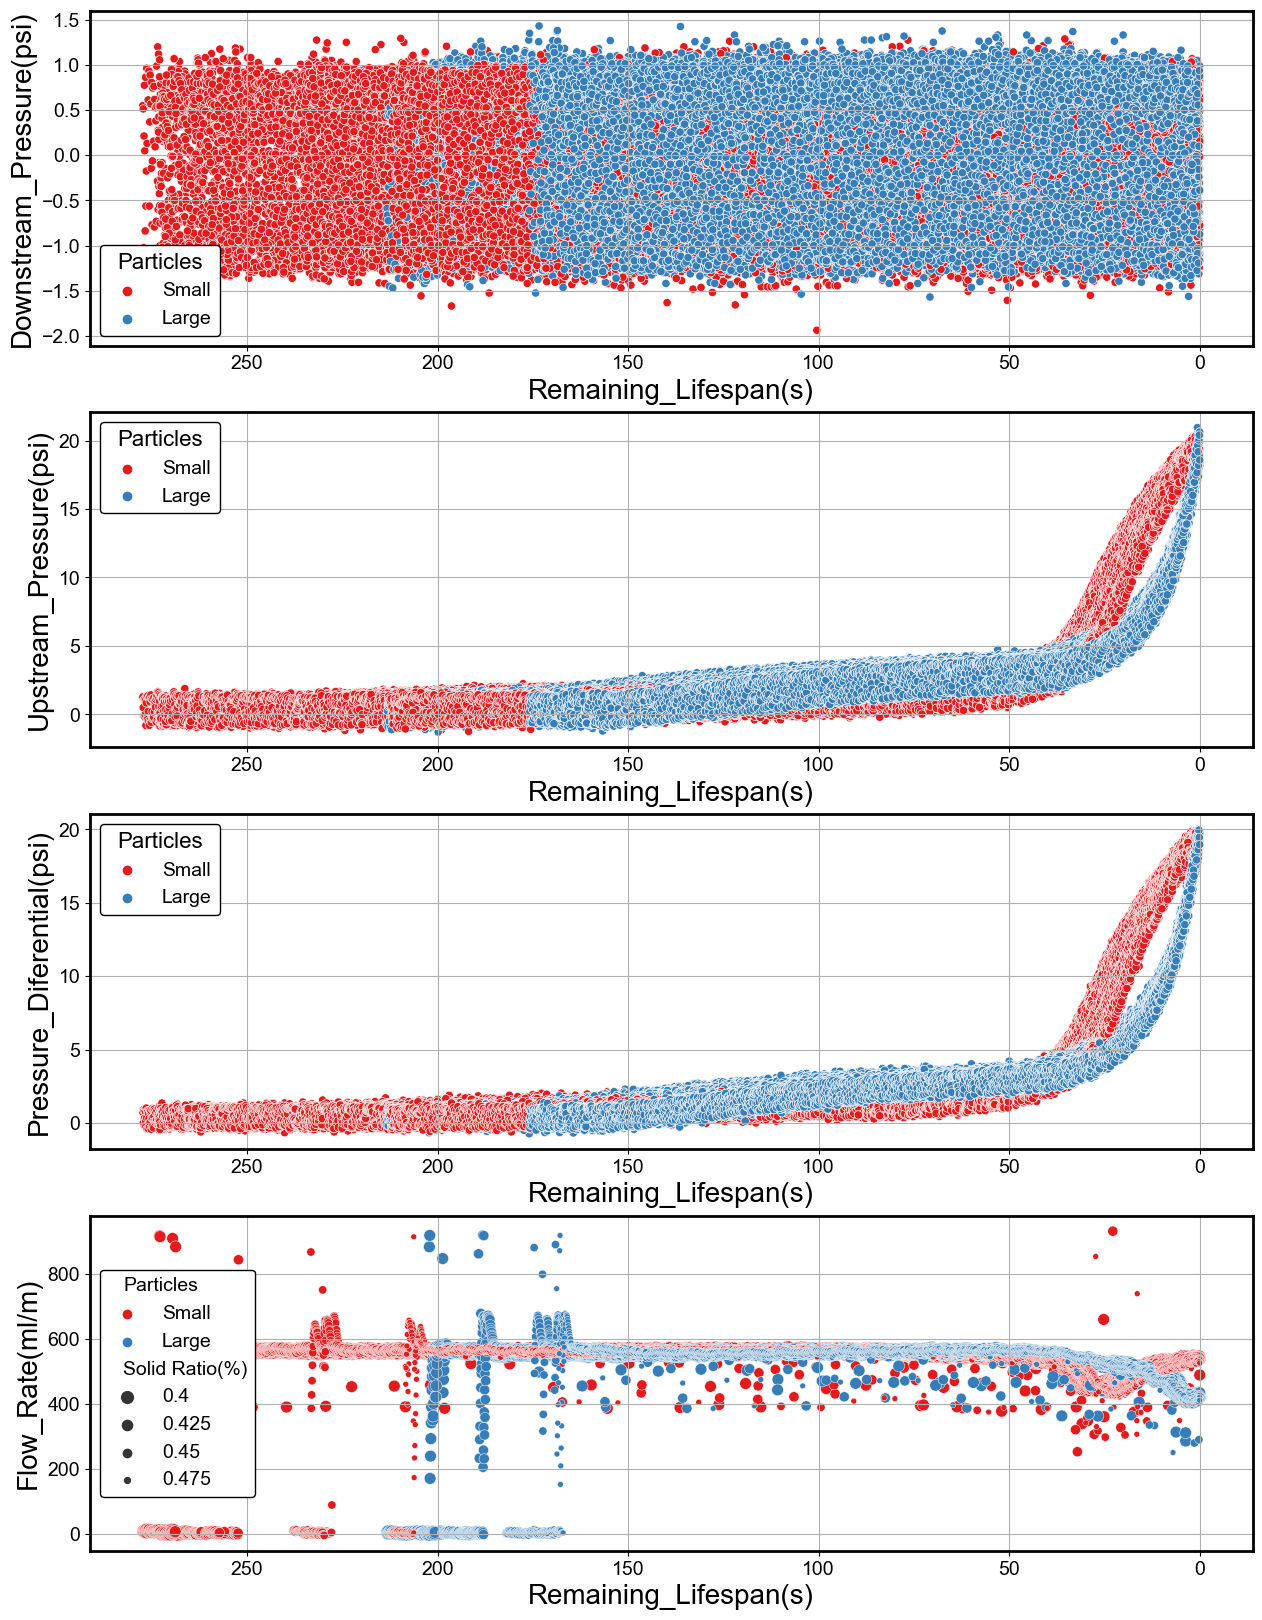

In [ ]:
# Plotando variaveis pelo tempo util

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,20))
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Downstream_Pressure(psi)', hue= 'Particles', palette= 'Set1', ax=ax1, data=Df)
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Upstream_Pressure(psi)', hue= 'Particles', palette= 'Set1', ax=ax2, data=Df)
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Pressure_Diferential(psi)', hue= 'Particles', palette= 'Set1', ax=ax3, data=Df)
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles',size='Solid Ratio(%)', palette= 'Set1', ax=ax4, data=Df)
# ax1.set(ylim=(300, 700))
# ax1.set(xlim=(0.1,300))
ax1.invert_xaxis()

# ax2.set(ylim=(0, 25))
# ax2.set(xlim=(0.1,300))
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()



/Users/Dudu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[(0.0, 800.0)]

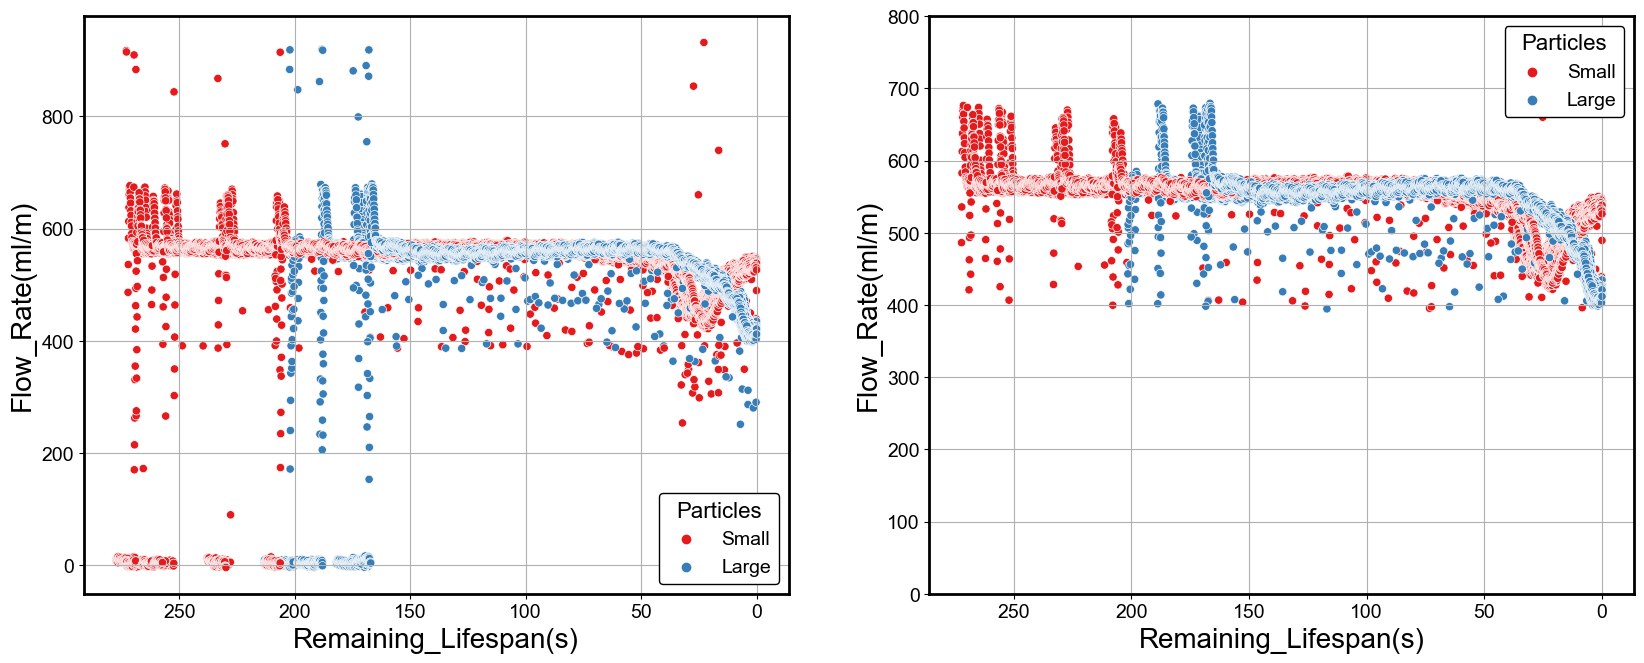

In [13]:
# Removendo outliers

def outlier2nan(df, fator):
    q3, q1 = np.percentile(df, [75, 25])
    iqr = q3 - q1
    lowerlimit = q1 - (iqr*fator)
    upperlimit = q3 + (iqr*fator)
    df.loc[(df < lowerlimit) | (df > upperlimit)] = np.nan

df_semoutlier = Df.copy()
outlier2nan(df_semoutlier["Flow_Rate(ml/m)"], 10)
df_semoutlier.dropna(inplace=True)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,7.5))
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles', palette= 'Set1', ax=ax1, data=Df)
ax1.invert_xaxis()
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles', palette= 'Set1', ax=ax2, data=df_semoutlier)
ax2.invert_xaxis()
ax2.set(ylim=(00,800))

<AxesSubplot:xlabel='Particles', ylabel='Remaining_Lifespan(s)'>

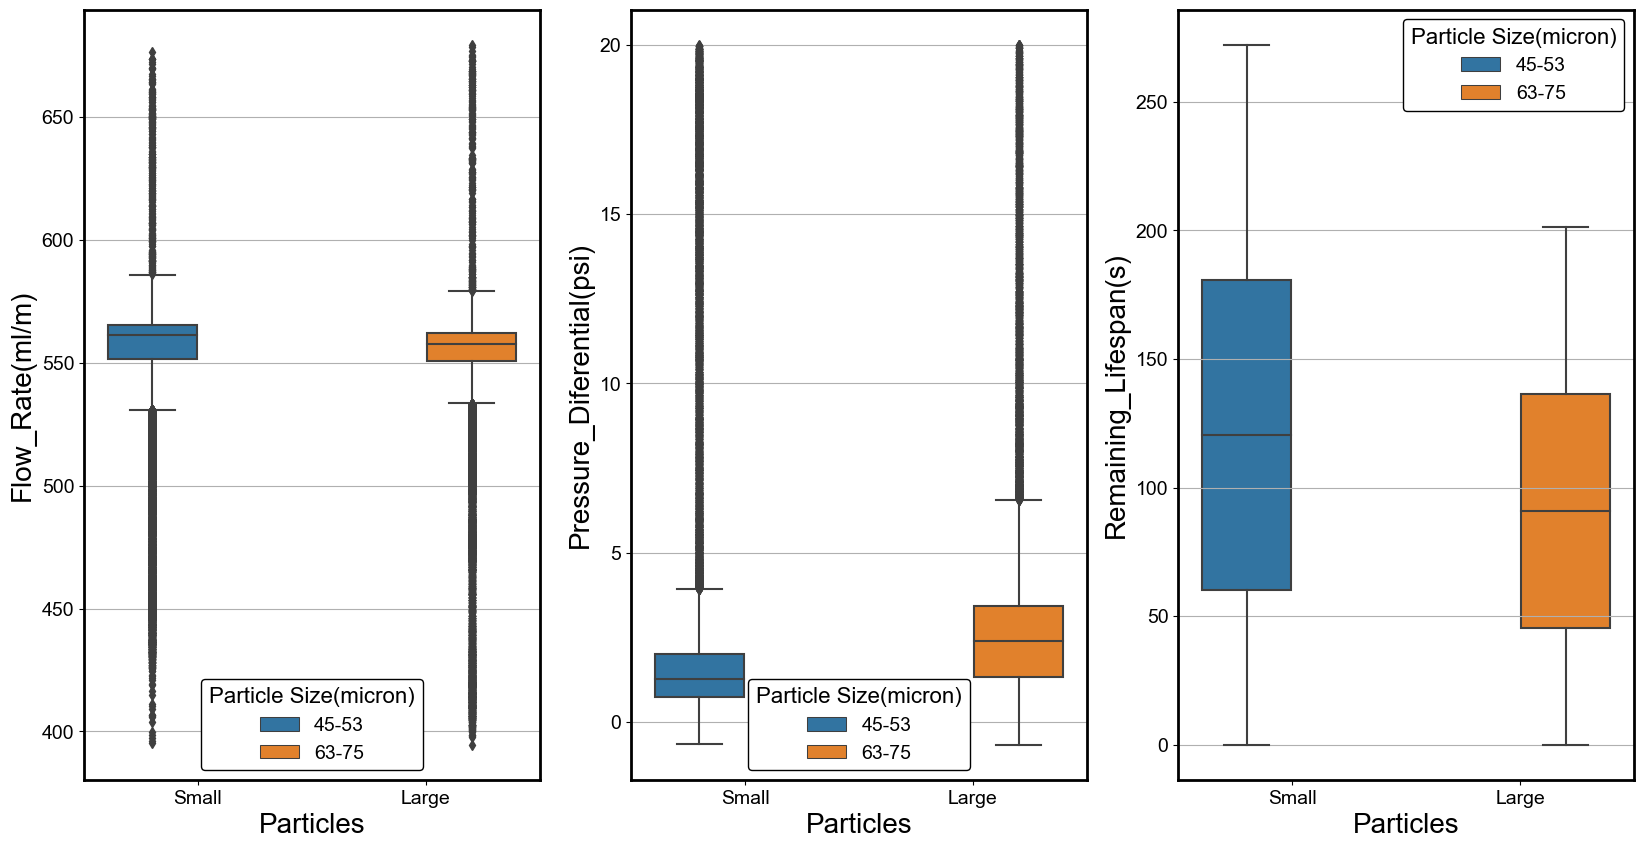

In [ ]:
fig, (ax, ax1,ax2) = plt.subplots(1,3,figsize=(20,10))
sns.boxplot(x='Particles',y='Flow_Rate(ml/m)',data=df_semoutlier, hue="Particle Size(micron)", ax=ax)
sns.boxplot(x='Particles',y='Pressure_Diferential(psi)',data=df_semoutlier, hue="Particle Size(micron)", ax=ax1)
sns.boxplot(x='Particles',y='Remaining_Lifespan(s)',data=df_semoutlier, hue="Particle Size(micron)", ax=ax2)

<AxesSubplot:xlabel='Particles', ylabel='count'>

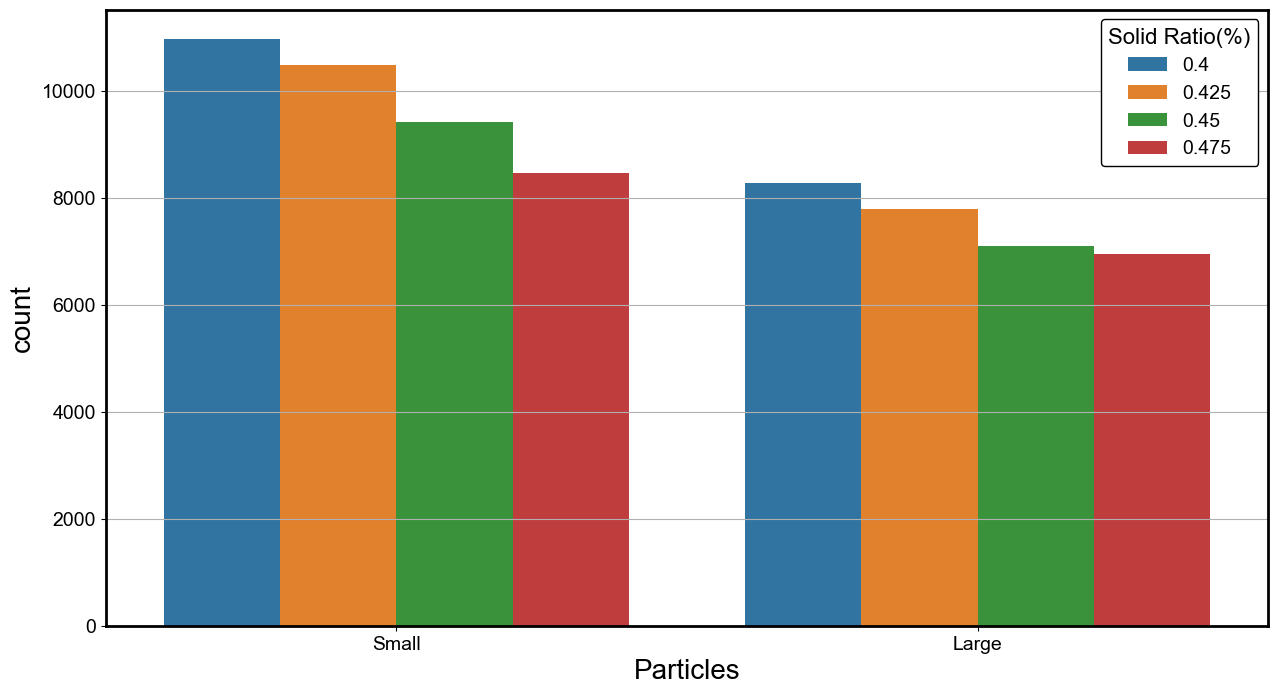

In [ ]:
fig, (ax) = plt.subplots(figsize=(15,8))
sns.countplot(data=Df, hue='Solid Ratio(%)', x="Particles", ax=ax)
# sns.countplot(data=Df, x='Particles', ax=ax)

In [ ]:
# data_description=Df_filtred.describe()
# data_description

In [ ]:
# sns.relplot(y="Pressure_Diferential(psi)", x="Flow_Rate(ml/m)",hue="Particles", 
#             col="Particles", data=Df);

#(Df.loc[((Df['sample']>=1) & (Df['sample']<=12))])
#sns.relplot(x=Df["Particles"],y=Df["Pressure_Diferential(psi)"],kind="line", data=Df)

In [ ]:

# fig, (ax,ax2) = plt.subplots(2, 1, figsize=(10,10))
# sns.lineplot(x="Remaining_Lifespan(s)", y="Pressure_Diferential(psi)",ax=ax,hue="Particles", data=Df_filtred)
# ax.invert_xaxis()
# sns.lineplot (x="Remaining_Lifespan(s)", y="Flow_Rate(ml/m)", ax=ax2, hue="Particles", data=Df_filtred)
# ax2.invert_xaxis()

# ax2.plot(Df["Remaining Lifespan(s)"], Df["Flow_Rate(ml/m)"])
# ax2.invert_xaxis()

In [ ]:
# fig, ax = plt.subplots(ncols = 1, nrows = len(pressoes), figsize = (10, 5*len(pressoes)))
# ax = ax.reshape((len(pressoes),))
# aux_df = Df.groupby('Particles')

# for pressao in range(len(pressoes)):  
#     ax[pressao].set_title(f'{pressoes[pressao]}', size = 20)
    
#     #sns.scatterplot(data = aux_df, x = 'Remaining Lifespan(s)', y= 'Flow_rate(ml/m)', label = 'Partículas pequenas', hue = 'sample')

#     sns.scatterplot(data = aux_df.get_group(0)[pressoes[pressao]], ax = ax[pressao], label = 'Partículas pequenas')
#     sns.scatterplot(data = aux_df.get_group(1)[pressoes[pressao]], ax = ax[pressao], label = 'Partículas grandes')
    
#     ax[pressao].legend()
#     ax[pressao].grid()

    
# # seaborn
# # hue


In [ ]:
# Df_filtred["Remaining_Lifespan(s)"].loc[(Df_filtred["Particles"]=='Small')]

# Análise Exploratória dos Dados

In [14]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69483 entries, 0 to 69482
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      69483 non-null  int64  
 1   Time(s)                    69483 non-null  float64
 2   Flow_Rate(ml/m)            69483 non-null  float64
 3   Upstream_Pressure(psi)     69483 non-null  float64
 4   Downstream_Pressure(psi)   69483 non-null  float64
 5   Pressure_Diferential(psi)  69483 non-null  float64
 6   sample                     69483 non-null  int64  
 7   Remaining_Lifespan(s)      69483 non-null  float64
 8   Particles                  69483 non-null  object 
 9   Particle Size(micron)      69483 non-null  object 
 10  Solid Ratio(%)             69483 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 5.8+ MB


In [15]:
# Excluindo coluna "Index, Time(s), sample"
#Df_filtred=df_semoutlier.drop(columns=['Time(s)','sample', 'index', 'Particles', 'Particle Size(micron)', 'Solid Ratio(%)'])
Df_filtred=df_semoutlier.drop(columns=['Time(s)', 'index', 'Particle Size(micron)'])
Df_filtred

Flow_Rate(ml/m)  Upstream_Pressure(psi)  Downstream_Pressure(psi)  \
78          578.030105                -0.93125                  -0.89375   
79          597.575338                -0.14375                  -1.20625   
80          631.927566                -0.20000                  -1.13750   
81          653.447065                 0.04375                  -0.89375   
82          664.305528                 0.01875                  -0.96875   
...                ...                     ...                       ...   
69478       406.959957                19.17500                   0.55625   
69479       410.908489                18.18750                  -1.19375   
69480       402.813998                20.04375                   0.10000   
69481       412.389188                20.39375                   0.93750   
69482       411.796909                18.58125                  -0.38750   

       Pressure_Diferential(psi)  sample  Remaining_Lifespan(s) Particles  \
78                      -0.03750       1                  265.5     Small   
79                       1.06250       1                  265.4     Small   
80                       0.93750       1                  265.3     Small   
81                       0.93750       1                  265.2     Small   
82                       0.98750       1                  265.1     Small   
...                          ...     ...                    ...       ...   
69478                   18.61875      48                    0.4     Large   
69479                   19.38125      48                    0.3     Large   
69480                   19.94375      48                    0.2     Large   
69481                   19.45625      48                    0.1     Large   
69482                   18.96875      48                    0.0     Large   

      Solid Ratio(%)  
78               0.4  
79               0.4  
80               0.4  
81               0.4  
82               0.4  
...              ...  
69478          0.475  
69479          0.475  
69480          0.475  
69481          0.475  
69482          0.475  

[67576 rows x 8 columns]

Text(0.5, 1.0, 'Matrix de correlação de Pearson')

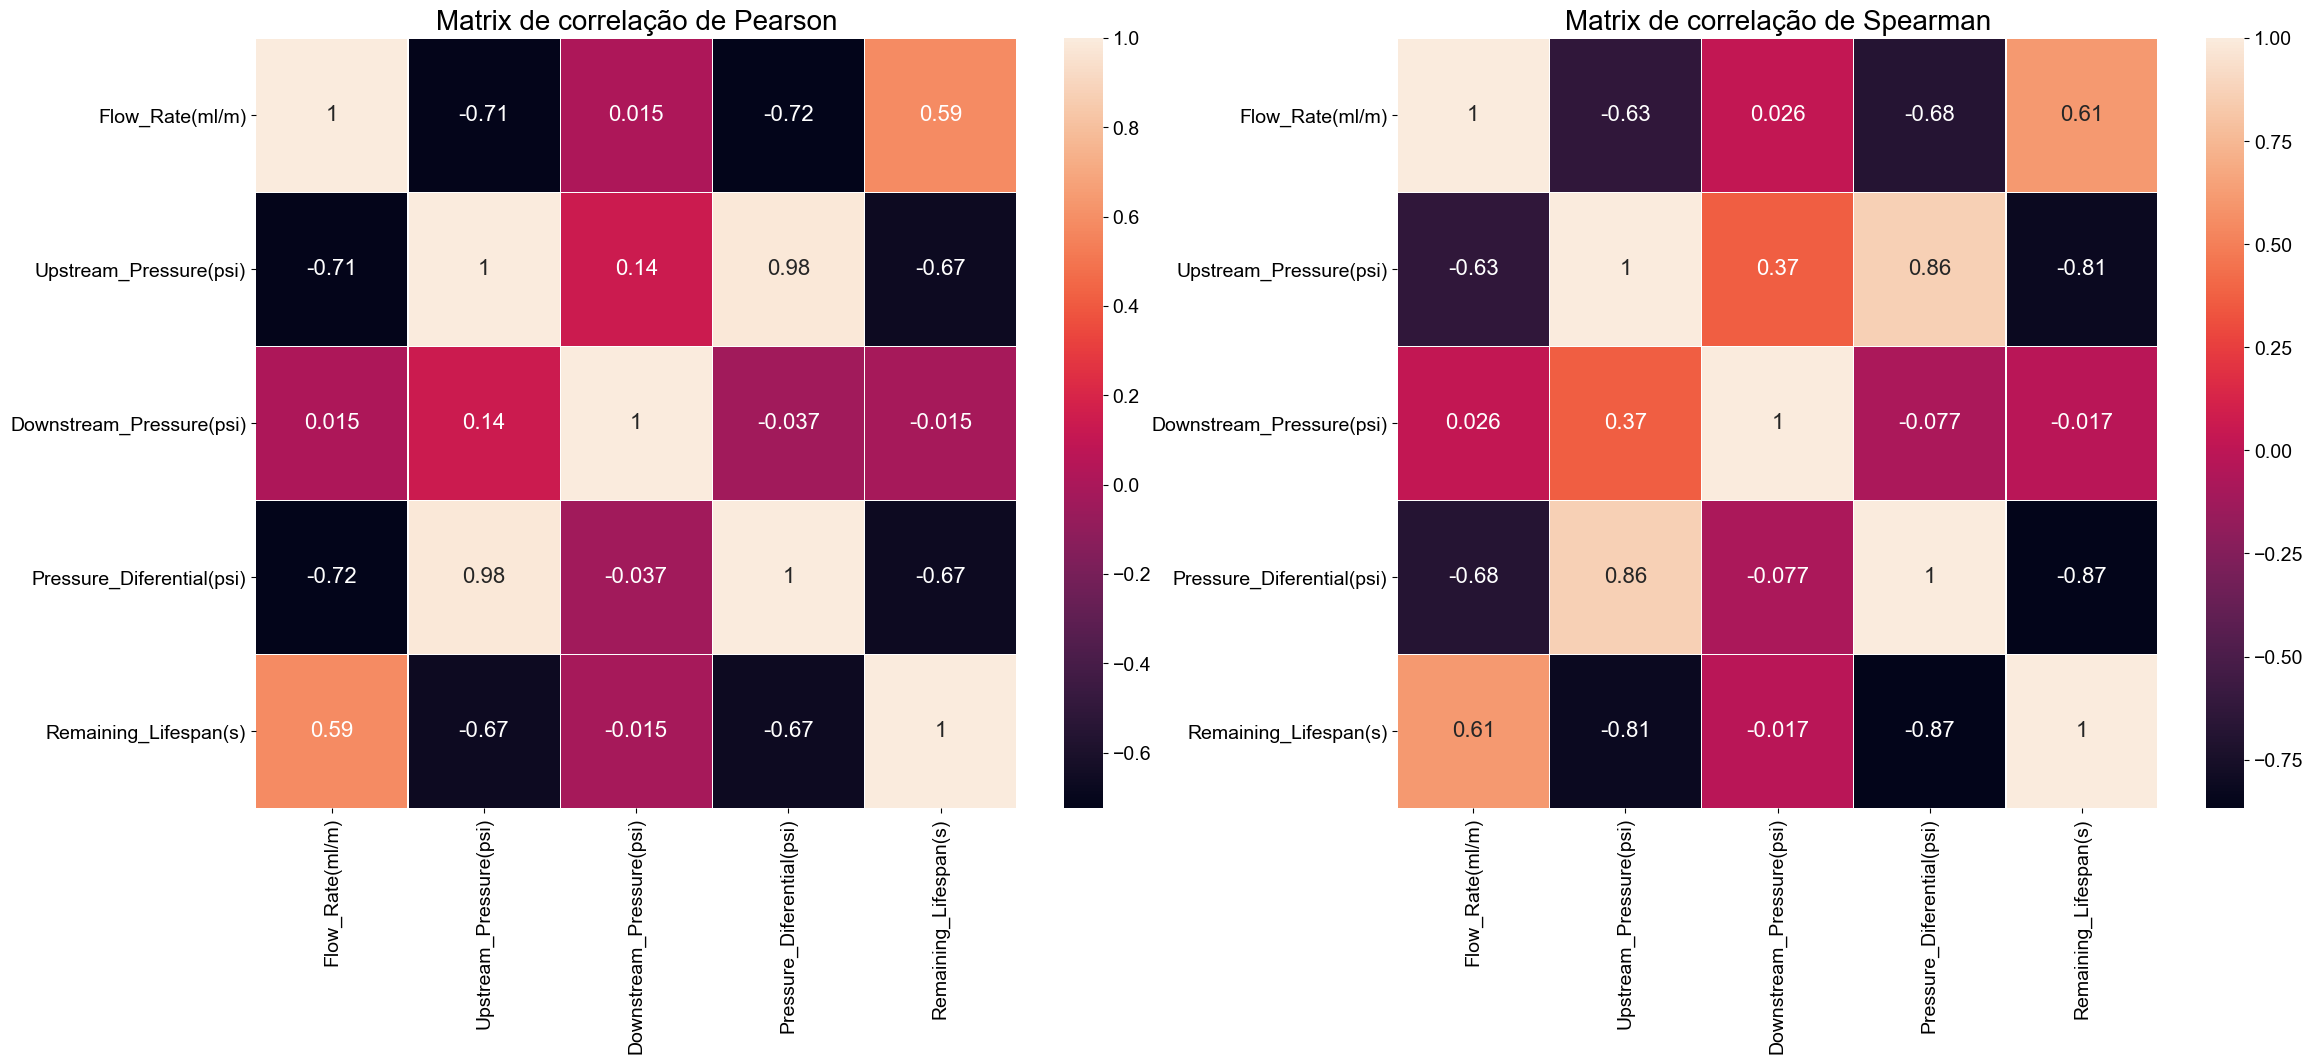

In [16]:
Df_col = ['Flow_Rate(ml/m)',	'Upstream_Pressure(psi)',	'Downstream_Pressure(psi)',	'Pressure_Diferential(psi)',	'Remaining_Lifespan(s)']

Df_plot = Df_filtred.copy()[Df_col]
df_corr1 = Df_plot.corr(method='spearman')
df_corr2 = Df_plot.corr(method='pearson')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(27,10))

sns.heatmap(df_corr1, linewidths=.2, annot=True,ax=ax2).set_title('Matrix de correlação de Spearman')
sns.heatmap(df_corr2, linewidths=.2, annot=True,ax=ax1).set_title('Matrix de correlação de Pearson')



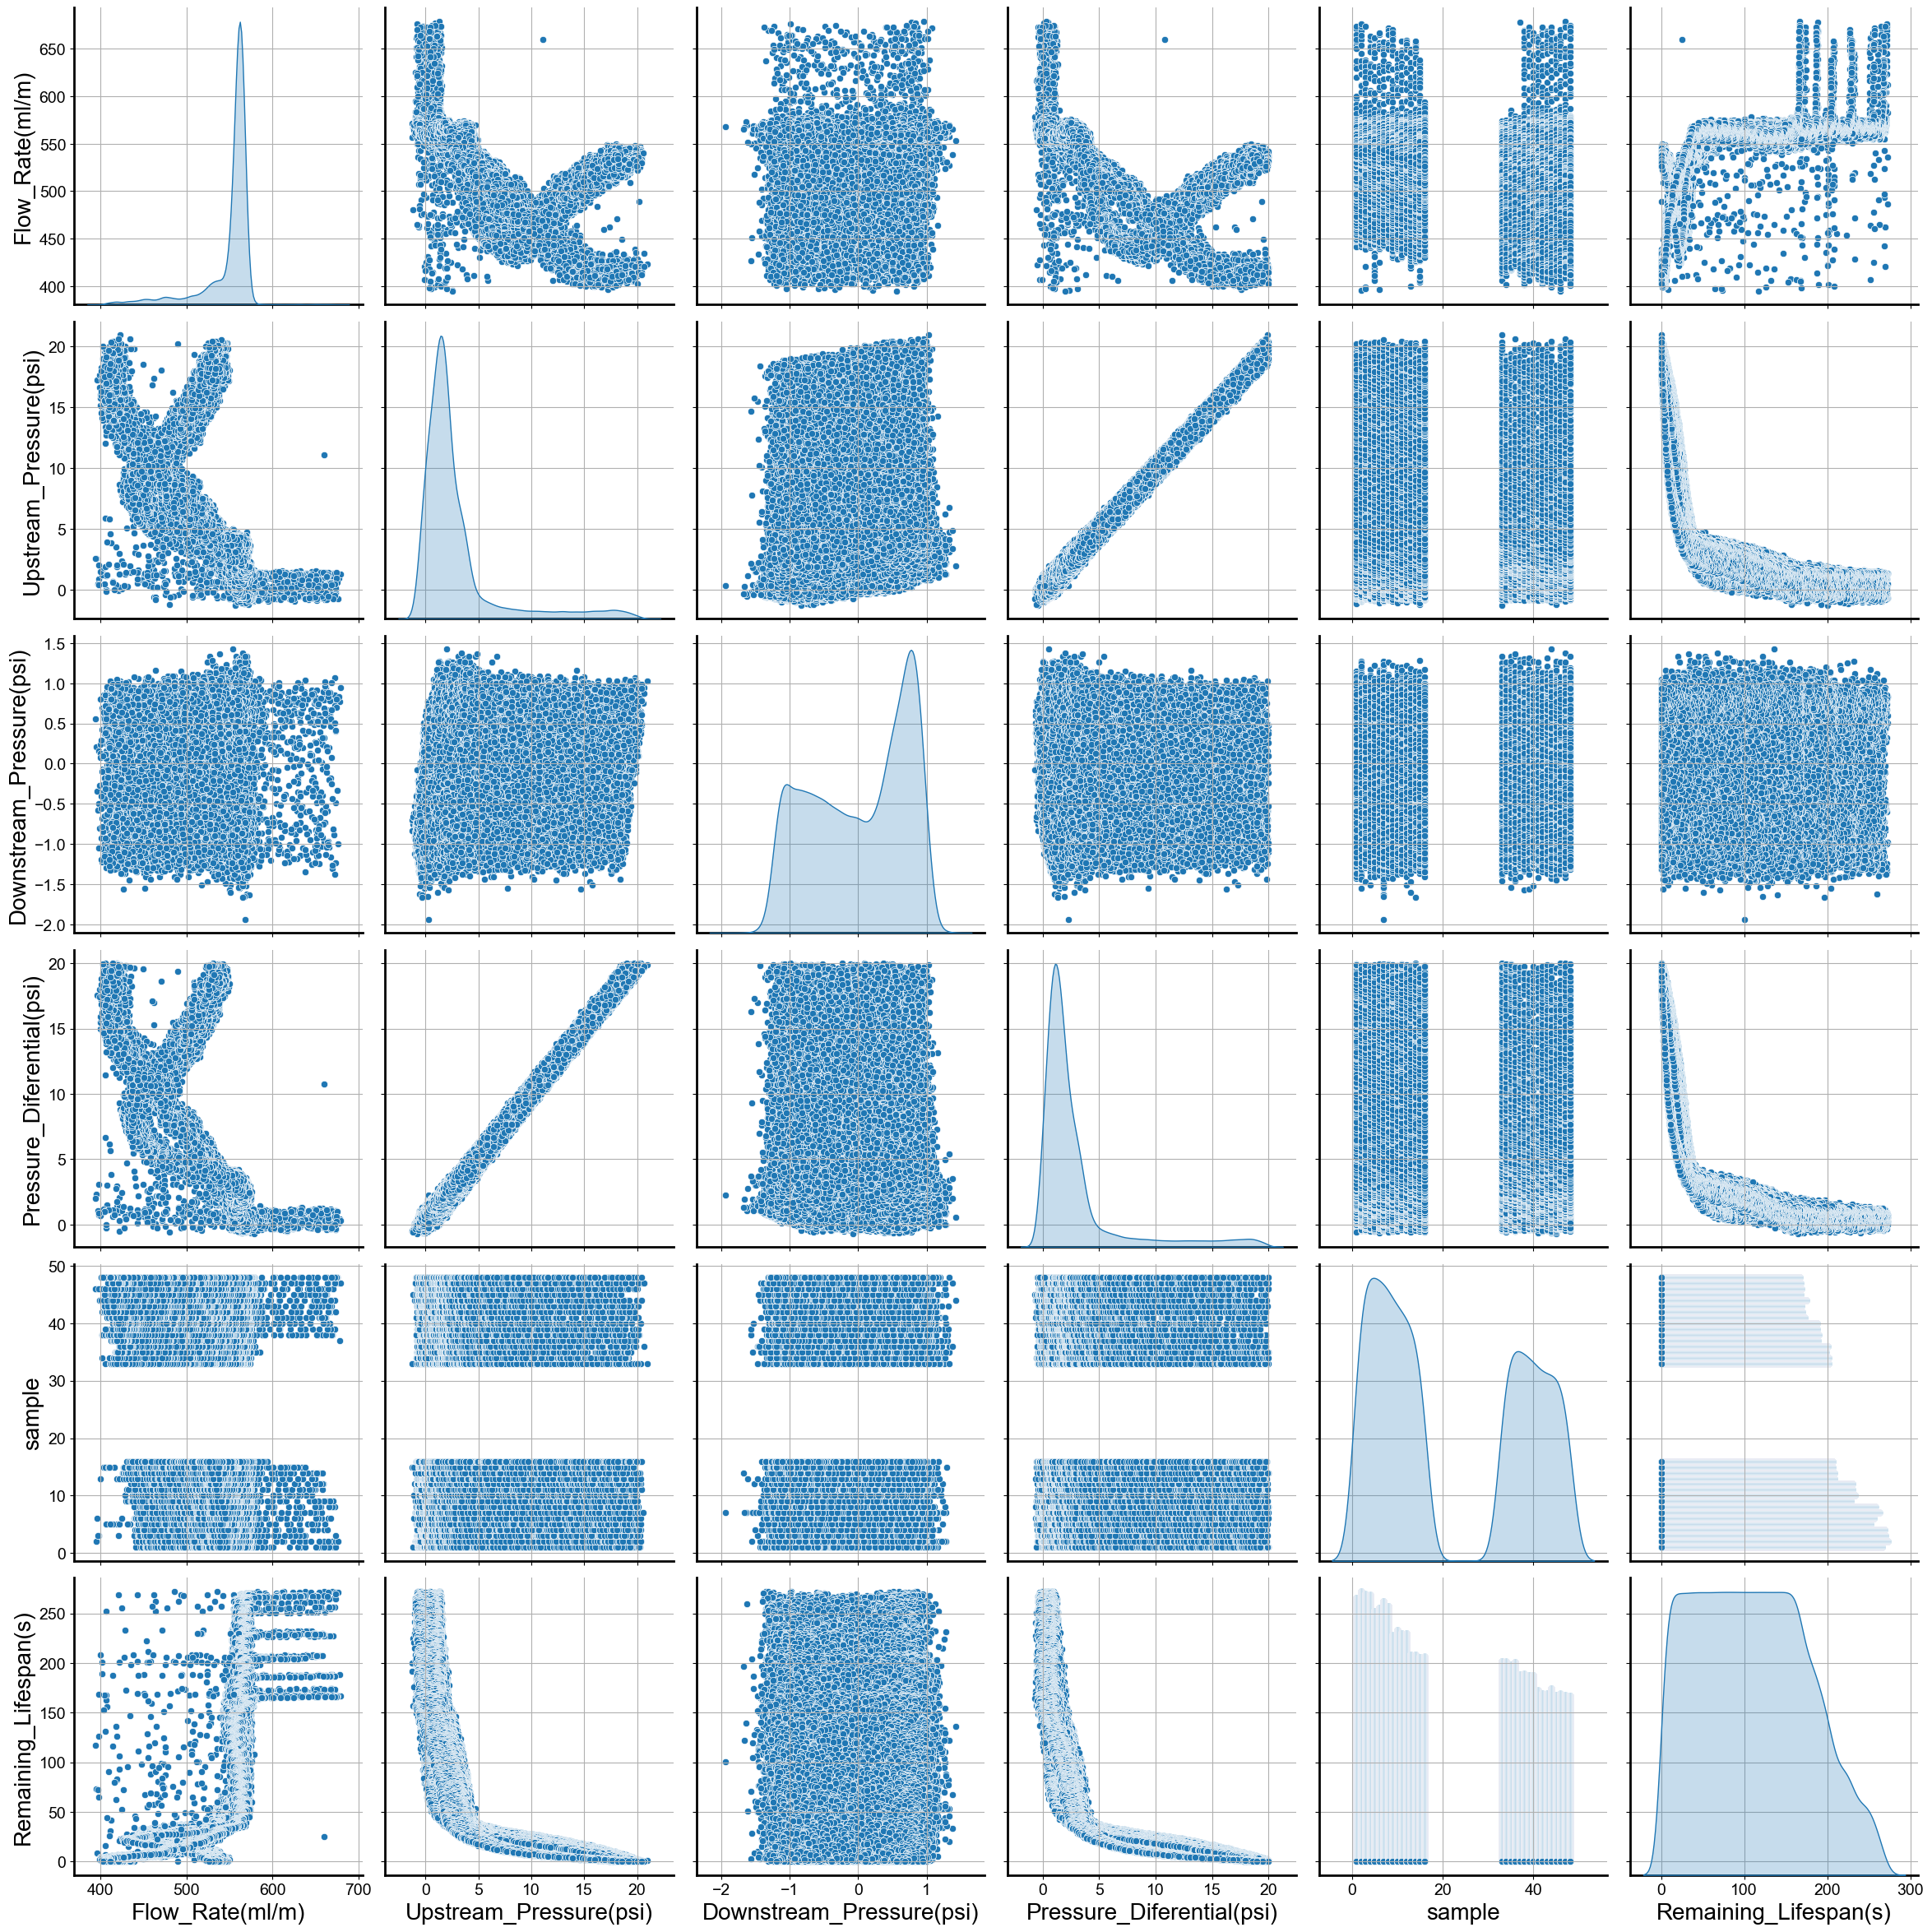

In [17]:
Df_col = ['Flow_Rate(ml/m)',	'Upstream_Pressure(psi)',	'Downstream_Pressure(psi)',	'Pressure_Diferential(psi)',	'Remaining_Lifespan(s)']

Df_plot = Df_filtred.copy()[Df_col]

sns.pairplot(Df_filtred, diag_kind='kde' ,height=4)

df_corr1 = Df_plot.corr(method='spearman')
df_corr2 = Df_plot.corr(method='pearson')
# fig, (ax1,ax2) = plt.subplots(1,2,figsize=(27,10))
# sns.pairplot(df_corr1)
# sns.pairplot(df_corr2, ax=ax2)


Text(0, 0.5, 'Flow rate (ml/min)')

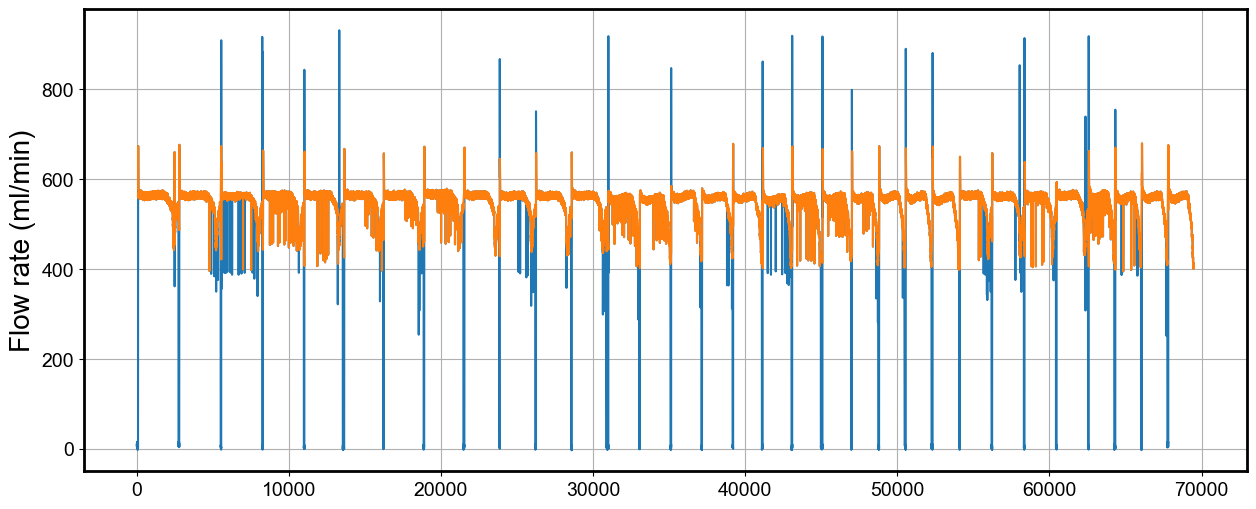

In [18]:
#Comparação da remoção de outliers
plt.plot(dataFrame['Flow_Rate(ml/m)'])
plt.plot(Df_filtred['Flow_Rate(ml/m)'])
plt.ylabel('Flow rate (ml/min)')

# Aplicação de Modelos

In [19]:
Df_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67576 entries, 78 to 69482
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Flow_Rate(ml/m)            67576 non-null  float64
 1   Upstream_Pressure(psi)     67576 non-null  float64
 2   Downstream_Pressure(psi)   67576 non-null  float64
 3   Pressure_Diferential(psi)  67576 non-null  float64
 4   sample                     67576 non-null  int64  
 5   Remaining_Lifespan(s)      67576 non-null  float64
 6   Particles                  67576 non-null  object 
 7   Solid Ratio(%)             67576 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 4.6+ MB


In [20]:
#Transformando objetos em valores
Df_filtred.loc[(Df_filtred['Particles'] == 'Small'),'Particles'] = 0
Df_filtred.loc[(Df_filtred['Particles'] == 'Large'),'Particles'] = 1
Df_filtred['Particles'] = Df_filtred['Particles'].astype('int64')

Df_filtred['Solid Ratio(%)'] = Df_filtred['Solid Ratio(%)'].astype('float64')

In [21]:
Df_filtred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67576 entries, 78 to 69482
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Flow_Rate(ml/m)            67576 non-null  float64
 1   Upstream_Pressure(psi)     67576 non-null  float64
 2   Downstream_Pressure(psi)   67576 non-null  float64
 3   Pressure_Diferential(psi)  67576 non-null  float64
 4   sample                     67576 non-null  int64  
 5   Remaining_Lifespan(s)      67576 non-null  float64
 6   Particles                  67576 non-null  int64  
 7   Solid Ratio(%)             67576 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 4.6 MB


#  Random Forest Regressor

In [23]:
#Selecionando 3 samples do small e 3 samples do Large aleatoriamente
import numpy

randnums = [*numpy.random.randint(1,16,3), *numpy.random.randint(33,48,3)]
dataFrames_test = []
dataFrames_train = []

for sample in randnums:
    dataFrames_test.append(Df_filtred.loc[Df_filtred['sample'] == sample])

dataFrame_test = pd.concat(dataFrames_test).reset_index(); #Concatenando dataframes
df_test = dataFrame_test.drop(columns=['sample', 'index']) #Dropando colunas desnecessárias
y_test = df_test['Remaining_Lifespan(s)'] #Coluna de teste para validar regressão do modelo
df_test = df_test.loc[:, df_test.columns != 'Remaining_Lifespan(s)'] #Dataframe de teste para testar modelo

In [39]:
#Selecionando 3 samples do small e 3 samples do Large aleatoriamente
import numpy

randnums = [*numpy.random.randint(1,16,3), *numpy.random.randint(33,48,3)]
dataFrames_test = []
dataFrames_train = []

for sample in randnums:
    dataFrames_test.append(Df_filtred.loc[Df_filtred['sample'] == sample])
    dataFrames_train.append(Df_filtred.loc[Df_filtred['sample'] != sample])


dataFrame_test = pd.concat(dataFrames_test).reset_index(); #Concatenando dataframes
dataFrame_train = pd.concat(dataFrames_train).reset_index(); #Concatenando dataframes

dataFrame_train = dataFrame_train.drop(columns=['index']) #Dropando colunas desnecessárias

df_test = dataFrame_test.drop(columns=['sample', 'index']) #Dropando colunas desnecessárias
y_test = df_test['Remaining_Lifespan(s)'] #Coluna de teste para validar regressão do modelo
df_test = df_test.loc[:, df_test.columns != 'Remaining_Lifespan(s)'] #Dataframe de teste para testar modelo

In [40]:
#Separando variáveis dependentes e independentes
#Variável dependente:
# df = df_semoutlier.drop(columns=['Time(s)','sample', 'index'])
df = dataFrame_train.copy()#Df_filtred.copy()
df = df.drop(columns=['sample']) #Dropando colunas desnecessárias
y_train = df['Remaining_Lifespan(s)']
X_train = df.loc[:, df.columns != 'Remaining_Lifespan(s)']

X_train.describe()

Flow_Rate(ml/m)  Upstream_Pressure(psi)  Downstream_Pressure(psi)  \
count    392665.000000           392665.000000             392665.000000   
mean        549.267060                2.933259                  0.017115   
std          30.545072                3.915621                  0.705041   
min         394.620795               -1.281250                 -1.937500   
25%         550.785234                0.875000                 -0.625000   
50%         559.570718                1.750000                  0.125000   
75%         564.111529                3.156250                  0.668750   
max         679.309950               20.937500                  1.425000   

       Pressure_Diferential(psi)      Particles  Solid Ratio(%)  
count              392665.000000  392665.000000   392665.000000  
mean                    2.916144       0.430497        0.435227  
std                     3.877427       0.495146        0.027725  
min                    -0.675000       0.000000        0.400000  
25%                     0.906250       0.000000        0.400000  
50%                     1.643750       0.000000        0.425000  
75%                     2.981250       1.000000        0.450000  
max                    20.000000       1.000000        0.475000

In [45]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
               }

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 40,
    cv = 3, verbose=2,
    random_state=42,
    n_jobs = -1)

rf_random.fit(X_train, y_train)

rf_random.best_params_



Fitting 3 folds for each of 40 candidates, totalling 120 fits


KeyboardInterrupt: 

In [41]:
#Importando Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

#Criando obj Random Forest Regressor
#RFReg = RandomForestRegressor(n_estimators = 215, random_state = 1)
RFReg = RandomForestRegressor(bootstrap=True,  max_depth=25, min_samples_leaf=2, min_samples_split=2,n_estimators=10)

#Fit the random forest regressor with training data represented by X_train and y_train
RFReg.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=10)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
    
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, df_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [42]:
#Teste
#Criando dataFrames para cada arquivo
y_predict_rfr = RFReg.predict((df_test))


In [43]:
from sklearn import metrics
r_square = metrics.r2_score(y_test,y_predict_rfr)
r_square

0.9981314252792681

In [46]:
#Validação cruzada
from sklearn.model_selection import cross_val_score
mse = cross_val_score(RFReg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mean_mse = numpy.mean(mse)
print(mean_mse)

-9.552538515267997


In [48]:
rmse = cross_val_score(RFReg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
rmse
mean_rmse = numpy.mean(rmse)

array([-3.70212939, -3.15753813, -2.82127952, -2.74613701, -2.84882741])

Text(0, 0.5, 'Remaining Lifespan (s)')

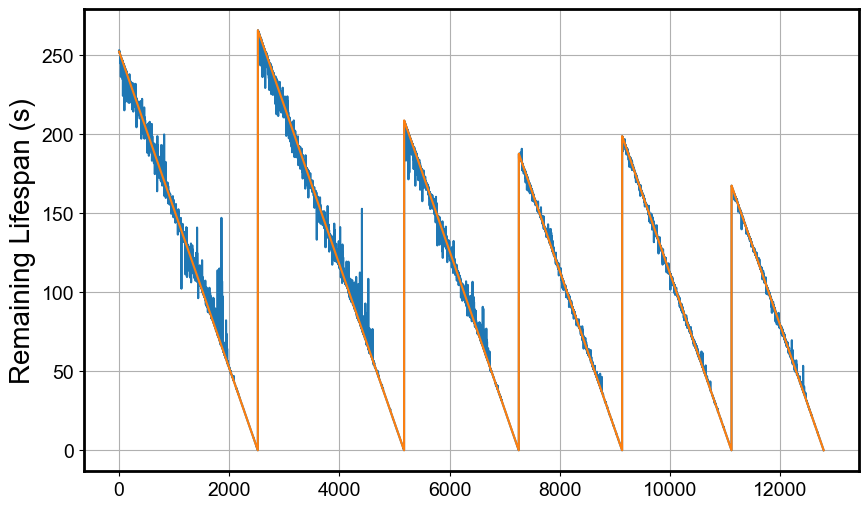

In [44]:
#plt.plot(y_test)
plt.figure(figsize=(10, 6))
plt.plot(y_predict_rfr)
plt.plot(y_test)
plt.ylabel('Remaining Lifespan (s)')

SyntaxError: invalid syntax (<ipython-input-51-66f6d61dbdd0>, line 1)